In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA
from pprint import pprint

In [4]:
patients = pd.read_csv('agg_data/patient.csv',index_col='PatientGuid').sort_index()
diagnosis = pd.read_csv('agg_data/diagnosis.csv',index_col='PatientGuid').sort_index()
physicisians = pd.read_csv('agg_data/physician_specialty.csv',index_col='PatientGuid').sort_index()
transcripts = pd.read_csv('agg_data/transcript.csv',index_col='PatientGuid').sort_index()
medications = pd.read_csv('agg_data/medication.csv',index_col='PatientGuid').sort_index()
data = pd.concat([diagnosis,physicisians,transcripts,patients],axis=1)
data['ID'] = range(data.shape[0])

To do:
1. sort categorical variables from numerical variables
2. standardize numerical variables
3. find import features
4. build predictive model
5. test and validate the model

In [3]:
target = 'DMIndicator'
categorical = ['Gender','State']
categorical += [x for x in data.columns if 'Icd' in x]
categorical += [x for x in data.columns if 'PhySp' in x]
numerical = data[[x for x in data.columns if (x not in categorical)]].columns.tolist()
categorical +=['ID']

In [46]:
def hist_numerical(df,col,nbins=10,target='DMIndicator',yscale='linear',normalize=False):
    x = df[col]
    hy1,hx1 = np.histogram(df[col][df[target] == 1],bins=nbins,normed=normalize)
    hy2,hx2 = np.histogram(df[col][df[target] == 0],bins=hx1,normed=normalize)
    w = 0.4*(hx1[1] - hx1[0])
    plt.figure(figsize=(5,3))
    plt.bar(hx1[:-1],hy1,width=w,color='blue',edgecolor='none')
    plt.bar(hx2[:-1]+w,hy2,width=w,color='green',edgecolor='none')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.yscale(yscale)
    plt.legend([1,0])
    print col, stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0])

def bar_categorical(df,col,target='DMIndicator',yscale='linear',normalize=False):
    x = pd.concat([data[data[target] == 1][col].value_counts(),data[data[target] == 0][col].value_counts()],axis=1)
    x.columns = [1,0]
    w = 0.4*(x.index[1] - x.index[0])
    plt.bar(x.index,x[1],color='b',width=w)
    plt.bar(x.index+w,x[0],color='g',width=w)
    return x


def box_numerical(df,col,target='DMIndicator',ylim=[0,25]):
    plt.figure(figsize=(5,3))
    plt.boxplot([df[col][df[target] == 0],df[col][df[target] == 1]])
    plt.xticks([1,2],[0,1])
    plt.ylim(ylim)
    plt.ylabel(col)
    print col,stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0])

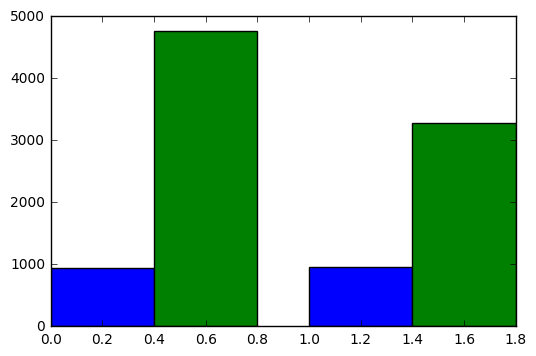

In [49]:
dd = bar_categorical(data,'Gender')
plt.show()

In [8]:
non_important = ['DiagnosisFreq','AcuteCount','Height_Max','Temperature_Max','Weight_Min','BMI_Min',
                 'RespiratoryRate_Min','Temperature_Std','Height_Mean','Height_Change','RespiratoryRate_Change',
                 'Temperature_Change']
outliers = ['AcuteCount','RespiratoryRate_Max','Temperature_Max','Weight_Min','BMI_Min','RespiratoryRate_Min',
            'Temperature_Std','']

Age Ttest_indResult(statistic=27.859596396767721, pvalue=1.5320221627513069e-164)
BMI_Max Ttest_indResult(statistic=20.782972073699653, pvalue=6.0134387449983657e-94)


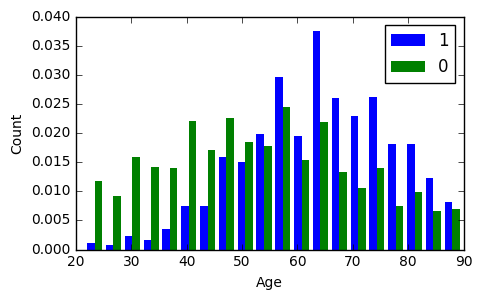

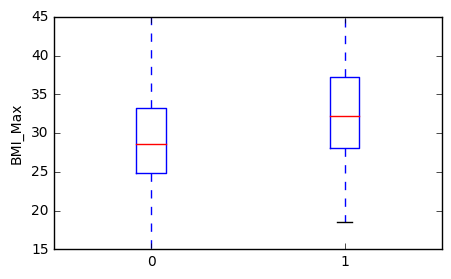

In [9]:
n = 2
#hist_numerical(data,numerical[n],nbins=20,yscale='linear',normalize=False)
hist_numerical(data,'Age',nbins=20,yscale='linear',normalize=True)
#hist_numerical(data,'BMI_Max',nbins=20,yscale='linear',normalize=True)
box_numerical(data,'BMI_Max',ylim=[15,45])
plt.show()
#print numerical[n], n,'/',len(numerical)

### PCA

In [357]:
def biplot(score,coeff,pcax,pcay,labels=None,nm=None):
    """
    This function generate a scatter plot to visualize important features resulting from a principle component analysis
    Given dataset X, the principle components analysis generates loadings (coefficients) L and scores (new features
    in the new basis) C such that X = L*C
    inputs:
        score (matrix): components in the new basis (C)
        coeff (matrix): also called loadings (L)
        pcax (int): one of the principle components to plot
        pcay (int): another principle to plot
    """
    pca1,pca2 = pcax-1,pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    if nm == None:
        nm = n
    #construct scales to constrain data between -1 and 1
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    
    #scatter data points in the new basis span by pca1 and pca2
    plt.scatter(xs*scalex,ys*scaley, marker='.',edgecolor='none')
    vectors = []
    
    #overlay transforms of original features in the new basis
    for i in range(n):
        #calculate length of vectors in new basis
        vectors.append((labels[i],np.sqrt(coeff[i,pca1]**2 + coeff[i,pca2]**2)))
        #plot arrow vectors
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='g',alpha=0.5) 
        #add labels
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='k', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    plt.show()
    #print "Feature import (PCA)"
    #print "--------------------"
    vectors = sorted(vectors,key=lambda x:x[1],reverse=False)
    
    plt.barh(range(len(vectors)),map(lambda x:x[1],vectors),edgecolor='none')
    plt.yticks(np.arange(len(vectors))+0.4,map(lambda x:x[0],vectors))
    plt.xlabel('Feature importance')
    plt.grid()
    plt.show()
    #pprint(vectors)
    return vectors

def standardize(ps,center="mean"):
    """
    This method standardize data to their center and a unity variance
    ps (pandas.series): data to be standardize
    center (str): central point {"mean","median"}
    """
    if center == "mean":
        return (ps - ps.mean()) / ps.std()
    if center == "median":
        return (ps - ps.median()[0]) / ps.std()
    else:
        print "unknown central point"
        return ps

number of useful components: 22


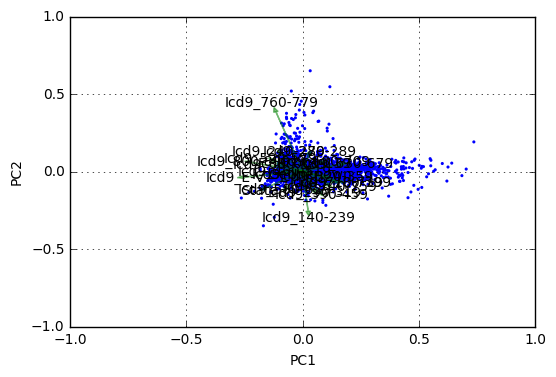

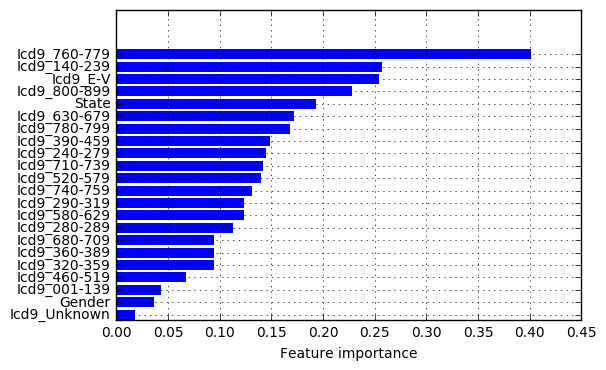

In [358]:
pca = PCA()
pca.fit(standardize(data[numerical]),data[target])
#pca.fit(data[numerical],data[target])
explained_var = pca.explained_variance_
n_comp = len(filter(lambda x:x>0.5, explained_var))
print "number of useful components:",n_comp

pca = PCA(n_components=n_comp)
#pca.fit(standardize(data[numerical]),data[target])
pca.fit(standardize(data[categorical]),data[target])
#pca.fit(data[numerical],data[target])

loadings = pca.components_
#scores = pca.transform(standardize(data[numerical]))
scores = pca.transform(standardize(data[categorical]))
#scores = pca.transform(data[numerical])

#vects = biplot(scores,loadings,1,2,labels=numerical)
vects = biplot(scores,loadings,1,2,labels=categorical)
vects = sorted(vects,key=lambda x:x[1],reverse=True)
plt.show()

labels_pca = map(lambda x:x[0],vects)

## Modeling

In [359]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [366]:
# import scikit learn libraries
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' by performing cross-validation. It works on both regression and classification
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cv or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print "\nModel report:"
        if scoring_method == 'roc_auc':
            print "Accuracy:",metrics.accuracy_score(dtrain[target].values,dtrain_predictions)
            print "AUC Score (Train):",metrics.roc_auc_score(dtrain[target], dtrain_predprob)
        if (scoring_method == 'mean_squared_error'):
            print "Accuracy:",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions)
    if performCV:
        print "CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn model,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    train: pandas.DataFrame, training data
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch

# plot optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.grid_scores_[i][1],alg.grid_scores_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# trees')
    plt.ylabel('score')
    plt.title('optimization report')

In [379]:
labels1 = map(lambda x:x[0],vects)+['ID']
labels2 = numerical[:]
labels2.pop(labels2.index('DMIndicator'))
labels3 = list(set(numerical).difference(set(non_important)))
labels3.pop(labels3.index('DMIndicator'))
labels4 = categorical[:]
labels5 = ['ID','Icd9_390-459', 'State', 'Icd9_240-279', 'PhySp_Internal_Medicine', 'PhySp_Family_Practice', 'PhySp_General_Practice', 'Icd9_780-799', 'PhySp_Unknown', 'Icd9_710-739', 'Icd9_E-V', 'Gender', 'PhySp_Geriatric_Medicine', 'Icd9_290-319', 'PhySp_Podiatry', 'PhySp_Cardiovascular_Disease', 'PhySp_Pulmonary_Disease', 'Icd9_580-629', 'PhySp_Endocrinology__Diabetes__Metabolism', 'PhySp_Adolescent_Medicine', 'PhySp_Nephrology', 'Icd9_280-289', 'Icd9_460-519', 'Icd9_320-359', 'Icd9_680-709', 'Icd9_520-579']
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels5],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()
labels1.pop(labels1.index('ID'))
labels2.pop(labels2.index('ID'))
labels3.pop(labels3.index('ID'))
labels4.pop(labels4.index('ID'))
labels5.pop(labels5.index('ID'))

'ID'

Best Parameters:
	{'n_estimators': 350}
Best Score:
	0.776352498332
Grid Scores:
[mean: 0.77555, std: 0.00806, params: {'n_estimators': 270},
 mean: 0.77605, std: 0.00822, params: {'n_estimators': 290},
 mean: 0.77603, std: 0.00862, params: {'n_estimators': 310},
 mean: 0.77614, std: 0.00838, params: {'n_estimators': 330},
 mean: 0.77635, std: 0.00882, params: {'n_estimators': 350},
 mean: 0.77581, std: 0.00887, params: {'n_estimators': 370},
 mean: 0.77587, std: 0.00861, params: {'n_estimators': 390},
 mean: 0.77605, std: 0.00906, params: {'n_estimators': 410},
 mean: 0.77576, std: 0.00928, params: {'n_estimators': 430},
 mean: 0.77584, std: 0.00877, params: {'n_estimators': 450},
 mean: 0.77547, std: 0.00849, params: {'n_estimators': 470},
 mean: 0.77521, std: 0.00845, params: {'n_estimators': 490}]

Model report:
Accuracy: 0.833266318188
AUC Score (Train): 0.827256272983
CV Score - Mean : 0.7763525 | Std : 0.008821432 | Min : 0.7622263 | Max : 0.7853977


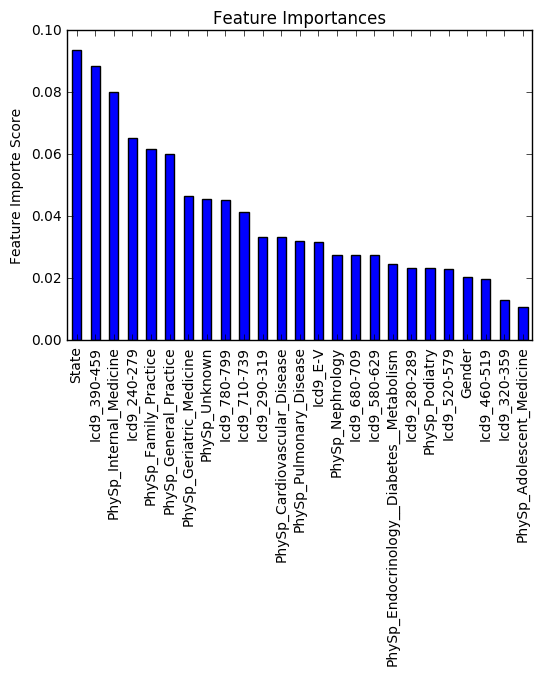

ROC AUC: 0.702908495751


In [382]:
gbm1 = GradientBoostingClassifier(
    learning_rate = 0.1,
    min_samples_split=2,
    max_depth=2,
    max_features='auto',
    subsample=0.8,
    random_state = 10
)
train = _Xtrain.copy()
train['DMIndicator'] = _Ytrain
param_test = {'n_estimators':range(270,501,20)}
predictors = labels5
#train[predictors] = standardize(train[predictors])
# optimize number of trees
gs_cls = optimize_num_trees(gbm1,param_test,'roc_auc',train,predictors,target)
print "Best Parameters:\n\t",gs_cls.best_params_
print "Best Score:\n\t",gs_cls.best_score_
print "Grid Scores:"
pprint(gs_cls.grid_scores_)

# cross validate the best model with optimized number of estimators
alg = modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc')

# testing on a different set
ypred = gs_cls.best_estimator_.predict(_Xvalid[predictors])
print "ROC AUC:", metrics.roc_auc_score(ypred,_Yvalid)


Model report:
Accuracy: 0.826028682482
AUC Score (Train): 0.813151476673
CV Score - Mean : 0.7755665 | Std : 0.01348876 | Min : 0.7525525 | Max : 0.7902665


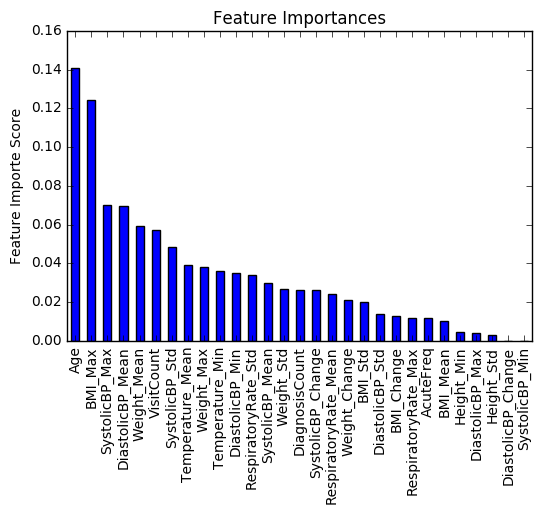


Model report:
Accuracy: 0.834740651387
AUC Score (Train): 0.82757019937
CV Score - Mean : 0.7743555 | Std : 0.008472267 | Min : 0.7636612 | Max : 0.7896208


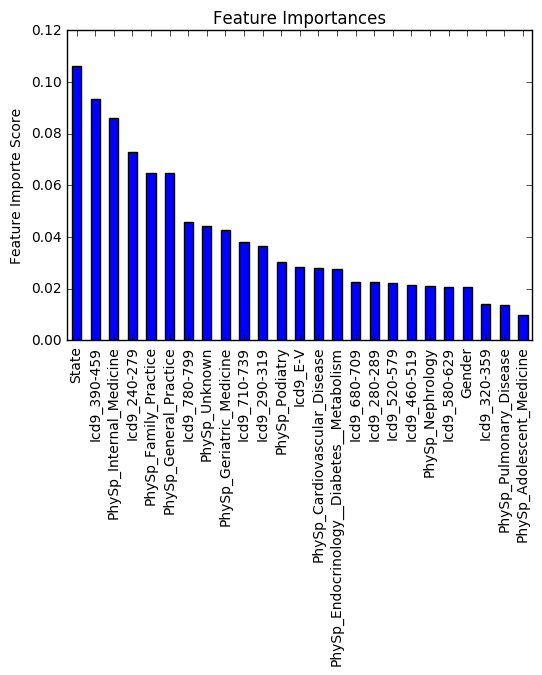

ROC AUC - num model: 0.706580465255
ROC AUC - cat model: 0.680448854745
ROC AUC - combo model: 0.753764510779


In [411]:
gbm_num = GradientBoostingClassifier(n_estimators = 90,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_cat = GradientBoostingClassifier(n_estimators = 350,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
train = data[data.ID.isin(_train_ids)]
valid = data[data.ID.isin(_valid_ids)]

alg_num = modelfit(gbm_num,train,labels3,target,'roc_auc')
alg_cat = modelfit(gbm_cat,train,labels5,target,'roc_auc')

ypred_num = alg_num.predict(valid[labels3])
ypred_cat = alg_cat.predict(valid[labels5])
ypredprob_num = alg_num.predict_proba(valid[labels3])[:,1]
ypredprob_cat = alg_cat.predict_proba(valid[labels5])[:,1]
ypred_combo = ((0.8*ypredprob_num + 0.2*ypredprob_cat)>0.5)*1
print "ROC AUC - num model:", metrics.roc_auc_score(ypred_num,valid[target])
print "ROC AUC - cat model:", metrics.roc_auc_score(ypred_cat,valid[target])
print "ROC AUC - combo model:", metrics.roc_auc_score(ypred_combo,valid[target])